# Проект HR-аналитика

## Описание задачи

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Необходимо решить две задачи. 

Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Описание данных

#### Задача 1: Уровень удовлетворенности сотрудника



Для этой задачи заказчик предоставил данные с признаками:
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

#### Задача 2: Прогнозирование увольнения сотрудника

Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это `quit` — увольнение сотрудника из компании.

## Импорт необходимых библиотек

In [1]:
!pip install shap
!pip install scikit-learn==1.1.3 -q
!pip install phik

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import shap
import phik

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.metrics import (
    roc_auc_score, 
    make_scorer
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Задача 1. Загрузка данных

In [3]:
train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', decimal='.')
print(train_job_satisfaction_rate.info())
train_job_satisfaction_rate.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


В столбцах `dept` и `level` есть пропуски, типы данных соответствуют содержанию.

In [4]:
test_features = pd.read_csv('/datasets/test_features.csv')
print(test_features.info())
test_features.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


В тестовой выборке также отсутствуют значения в столбцах `dept` и `level`, типы данных соответствуют действительности

In [5]:
test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
print(test_target_job_satisfaction_rate.info())
test_target_job_satisfaction_rate.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


Целевой признак тестовой выборки в порядке.

#### Вывод по первичному осмотру данных
____
В ходе первичного осмотра данных были обнаружены пропуски в тренировочном датасете и в тестовом датасете с входными признаками. На этапе предобработки посмотрим явные и неявные дубликаты, а также оценим наличие аномальных значений в выборке
____

## Предобработка данных

Прежде чем заниматься предобработкой напишем функцию, которая упростит этот этап

In [6]:
def check_data(data):
    
    #Количество дубликатов
    print('Количество дубликатов:', data.duplicated().sum())
    print()
    #Неявные дубликаты в строковых столбцах
    object_columns = data.select_dtypes(include='object').columns
    for column in object_columns:
        print(f'Cписок уникальных значений для столбца {column}')
        if column in data.columns:
            print(data[column].unique())
            print()
            
    #Числовой тип данных
    numeric_columns = data.select_dtypes(include='number').columns
    
    # Уникальные значения в числовых столбцах
    for column in numeric_columns:
        print(f'Cписок уникальных значений для столбца {column}')
        if column in data.columns:
            print(data[column].sort_values().unique())
            print()
            
    #Гистограммы для числового типа данных
    for column in numeric_columns:
        plt.figure(figsize=(6, 3))
        sns.histplot(data[column], bins=10, kde=True)
        plt.title(f'Гистограмма для {column}')
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.show() 
        

Количество дубликатов: 245

Cписок уникальных значений для столбца dept
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

Cписок уникальных значений для столбца level
['junior' 'middle' 'sinior' nan]

Cписок уникальных значений для столбца workload
['medium' 'high' 'low']

Cписок уникальных значений для столбца last_year_promo
['no' 'yes']

Cписок уникальных значений для столбца last_year_violations
['no' 'yes']

Cписок уникальных значений для столбца employment_years
[ 1  2  3  4  5  6  7  8  9 10]

Cписок уникальных значений для столбца supervisor_evaluation
[1 2 3 4 5]

Cписок уникальных значений для столбца salary
[12000 13200 14400 15600 16800 18000 19200 20400 21600 22800 24000 25200
 26400 27600 28800 30000 31200 32400 33600 34800 36000 37200 38400 39600
 40800 42000 43200 44400 45600 46800 48000 49200 50400 51600 52800 54000
 55200 56400 57600 58800 60000 61200 62400 63600 64800 66000 67200 68400
 69600 70800 72000 73200 74400 75600 76800 78000 79200 80400 81600 84000
 

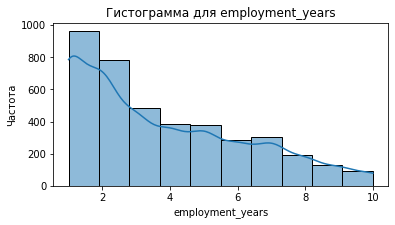

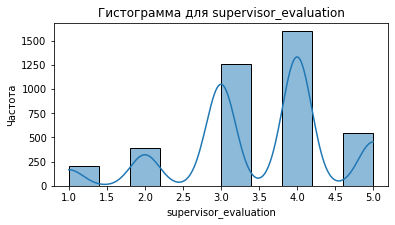

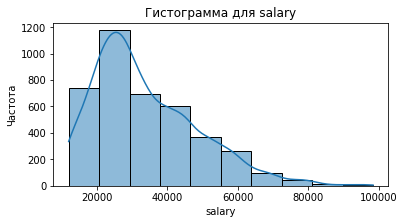

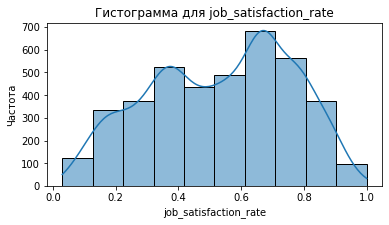

In [7]:
check_data(train_job_satisfaction_rate.drop('id', 1))

In [8]:
print('Количество явных дубликатов', train_job_satisfaction_rate.duplicated().sum())

Количество явных дубликатов 0


Количество дубликатов: 557

Cписок уникальных значений для столбца dept
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

Cписок уникальных значений для столбца level
['junior' 'middle' 'sinior' nan]

Cписок уникальных значений для столбца workload
['medium' 'low' 'high' ' ']

Cписок уникальных значений для столбца last_year_promo
['no' 'yes']

Cписок уникальных значений для столбца last_year_violations
['no' 'yes']

Cписок уникальных значений для столбца employment_years
[ 1  2  3  4  5  6  7  8  9 10]

Cписок уникальных значений для столбца supervisor_evaluation
[1 2 3 4 5]

Cписок уникальных значений для столбца salary
[12000 13200 14400 15600 16800 18000 19200 20400 21600 22800 24000 25200
 26400 27600 28800 30000 31200 32400 33600 34800 36000 37200 38400 39600
 40800 42000 43200 44400 45600 46800 48000 49200 50400 51600 52800 54000
 55200 56400 57600 58800 60000 61200 62400 63600 64800 66000 67200 68400
 69600 70800 72000 73200 75600 76800 78000 79200 80400 81600 82800

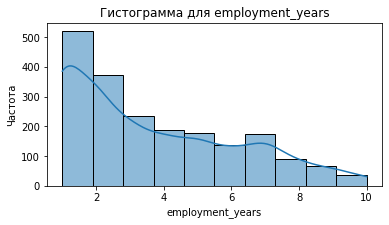

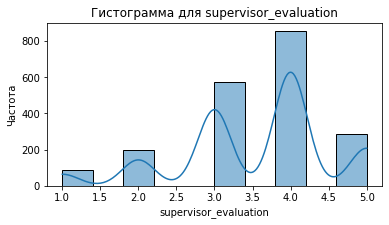

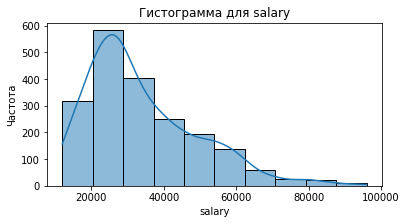

In [9]:
check_data(test_features.drop('id', 1))

In [10]:
print('Количество явных дубликатов', test_features.duplicated().sum())

Количество явных дубликатов 0


Количество дубликатов: 1902

Cписок уникальных значений для столбца job_satisfaction_rate
[0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15 0.16
 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3
 0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43 0.44
 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58
 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72
 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86
 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.  ]



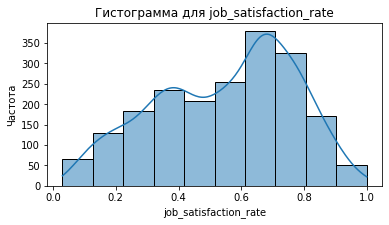

In [11]:
check_data(test_target_job_satisfaction_rate.drop('id', 1))

В ходе первичного анализа наших данных найдены следующие пункты для поправок:
 - Пустые значения `''` в тестовой выборке - заменить на np.nan.
 - np.nan значения будут заменены позже в пайплайне с помощью SimpleImputer.
 - Разный порядок наблюдений в тестовой выборке у входных данных и целевой переменной - отфильтруем эти датасеты в порядке возрастания по столбцу `id`, чтобы наблюдения совпадали. 

In [12]:
test_features['dept'] = test_features['dept'].replace(' ', np.nan)
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [13]:
test_features['workload'] = test_features['workload'].replace(' ', np.nan)
test_features['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

In [14]:
test_features = test_features.sort_values('id').reset_index(drop=True)
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,100298,hr,junior,low,2,no,no,4,19200
1,100480,marketing,junior,low,4,no,no,4,16800
2,100503,purchasing,middle,high,5,no,no,4,55200
3,100610,sales,middle,medium,5,no,no,4,43200
4,100692,sales,middle,high,6,no,no,4,48000


In [15]:
test_target_job_satisfaction_rate = test_target_job_satisfaction_rate.sort_values('id').reset_index(drop=True)
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,100298,0.80
1,100480,0.84
2,100503,0.79
3,100610,0.75
4,100692,0.69


#### Вывод по предобработке

В ходе предобработки наших данных было обнаружено, что:

- В столбцах `dept` и `level` тренировочной выборки присутствовали пропущенные значения. Их мы будем заполнять с помощью SimpleImputer, когда будем смотрить пайплайн для нашей модели. 

- В столбцах `dept`, `level` и `workload` тестовой выборки входных признаков были обнаружены пропущенные значения. С ними мы поступим по аналогии с предыдущим пунктом.

- Порядок наблюдений тестовой выборки у входных признаков и таргета различался. Было принято решение отсортировать обе таблицы по мере возрастания значений столбца `id`, чтобы наблюдения совпадали. 

## Исследовательский анализ данных

Для упрощенного EDA напишем функцию, которая покажет нам графики по всем столбцам и выведет основные статистики

In [16]:
def eda(data):
    #строковые столбцы
    object_columns = data.select_dtypes(include='object').columns
    
    #числовые столбцы
    numeric_columns = data.select_dtypes(include='number').columns
    
    #гистограммы и ящики с усами для числовых столбцов
    for column in numeric_columns:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
        
        sns.histplot(data[column], kde=False, bins=20, color='blue', alpha=0.5, ax=axes[0])
        axes[0].set_title(f'Гистограмма столбца\n{column}')
        axes[0].set_ylabel('Частота')
        axes[0].set_xlabel(f'{column}')
        axes[0].axvline(data[column].mean(), color='red', linestyle='dashed', linewidth=2, label='Среднее')
        axes[0].axvline(data[column].median(), color='blue', linestyle='dashed', linewidth=2, label='Медиана')
        axes[0].legend()

        sns.boxplot(x=data[column], ax=axes[1], color='skyblue')
        axes[1].set_title(f'Ящик с усами для\n{column}')
        axes[1].set_xlabel(f'{column}')

        plt.tight_layout()
        plt.show()

        print(data[column].describe())
    
    #Диаграммы для категориальных столбцов
    for column in object_columns:
        labels = data[column].value_counts().index
        sizes = data[column].value_counts().values

        plt.figure(figsize=(5, 5))
        plt.pie(
            sizes, 
            labels=labels, 
            autopct='%1.1f%%', 
            startangle=90, 
            colors=['lightblue', 'lightgreen', 'lightyellow', 'lightcoral', 'lightgrey', 'lightsalmon'])
        plt.title(f'Соотношение значений столбца\n{column} в датасете')
        plt.show()
        print(data[column].value_counts())

#### EDA train_job_satisfaction_rate

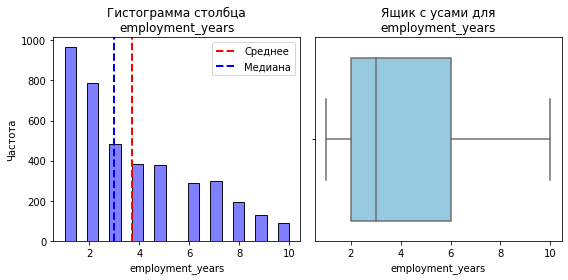

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


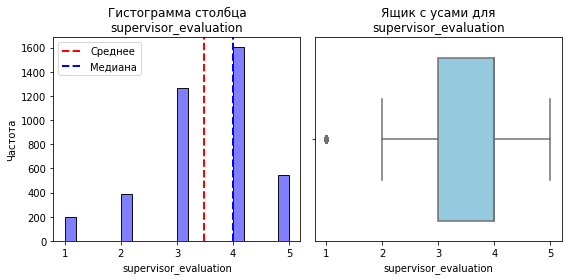

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


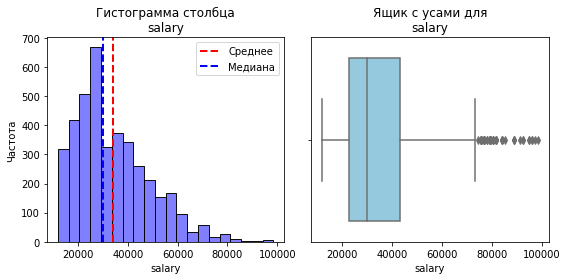

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64


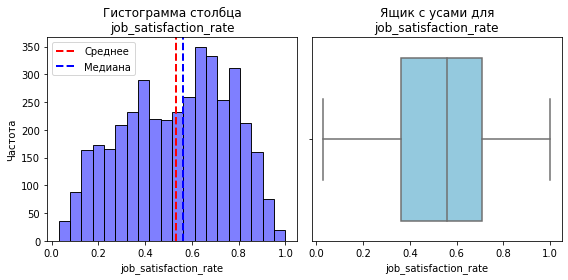

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


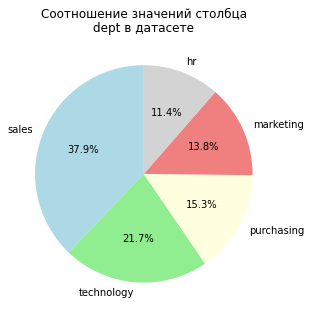

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64


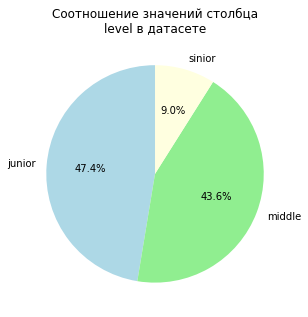

junior    1894
middle    1744
sinior     358
Name: level, dtype: int64


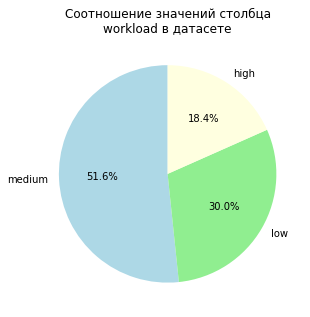

medium    2066
low       1200
high       734
Name: workload, dtype: int64


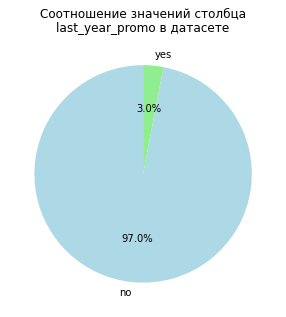

no     3880
yes     120
Name: last_year_promo, dtype: int64


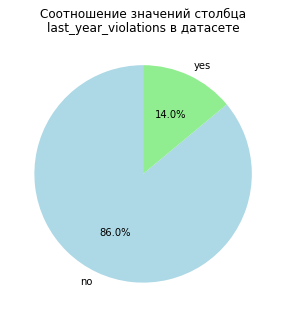

no     3441
yes     559
Name: last_year_violations, dtype: int64


In [17]:
eda(train_job_satisfaction_rate.drop('id', 1))

Начнем с первого графика. В нем содержаться данные столбца `employment_years`:
- Средняя длительность пребывания работников в компании составила 3.7 лет. При этом медианное значение составило 3
- Самое длительное пребывание сотрудника в компании составило 10 лет. Позже посмотрим **какая зарплата у таких сотрудников и почему они замотивированы продолжать работать в компании**
- Информативнее было бы **начертить столбчатую диаграмму**, т.к. этот столбец представлен в дискретных величинах.
_____
Следом идет оценка качества работы сотрудника, которую дал руководитель `supervisor_evaluation`:
- Наиболее популярная оценка, которую дали руководители, оценивая работу своих сотрудников, составила 4. При этом средняя оценка составила 3.5, что свидетельствует том, что мало руководителей оценили работу своих сотрудников на 5. **Для удобства начертим круговую диаграмму и посмотрим процентное соотношение оценок в датасете**
- Имееются выбросы возле оценки 1. **Далее проанализируем за что руководители так занижают оценку качества работы сотрудников**
___
Далее идет столбец с зарплатами в компании `salary`:
- Большая часть работников имеет зарплату до 400000 рублей
- Средняя зарплата в компании составила почти 34000 рублей. При этом медиана составила 30000 рублей, что свидетельствует о наличие выбросов справа от медианы. Это можно увидеть и на ящике с усами. Из-за того, что большая часть компании имеет зарплату до 40000 рублей все, кто имеет зарплату от ~72000 и выше - составили выбросы. Их мы удалять не будем, так как зарплаты менеджеров выше, нежели чем у линейных сотрудников и это тоже нужно учитывать при моделировании. Позже проверим **какая средняя зарплата у разных специалистов в зависимости от грейда**
- Самая максимальная зарплата составила 98400 рублей. Самая низкая - 12000.
___
Столбец с целевой переменной `job_satisfaction_rate`:
- Распределение нормальное, значительных смещений среднего и медианы не наблюдается. Удлиненных хвостов у гистограммы тоде нет.
- Есть сотрудники, уровень удовлетворенности работы которых составил 0.03. Серьезный показатель, думаю стоит **проанализировать столь низкую оценку удовлетворенности сотрудников работой в компании, чтобы найти возможные зоны роста** для кадрового управления.
- Средняя оценка удовлетворенности работой в компании составила 0.53. Максимсальная оценка составила 1.
- На ящике с усами и гистограмме отсутствут выбросы.
___
Подразделения компании представлены на круговой диаграмме с данными столбца `dept`:
- Всего в компании 5 подразделений
- Наибольшее по численности нанятых сотрудников подразделение - Продажи. Там находится 37.9% сотрудников компании.
- Далее у нас идет технологический отдел, его численность составили 866 сотрудников - 21.7%
- Снабжение, HR и маркетинг имеют примерно одинаковую долю в компании - 15.3%, 11.4%, 13.8% соответственно.
___
На очереди уровень грейда сотрудников компании `level`:
- Основная масса сотрудников компании состоит из специалистов уровней middle и junior - 43.6% и 47.4% соответственно
- Sinior - самый высший грейд - составили 9% сотрудников. Их не так много в компании. Скорее всего это связано либо со сложным уровнем аттестации для сотрудников данного грейда или же с ориентацией компании на молодых и неопытных сотрудников, которых проще обучить под собственные стандарты. Во всяком случае это нормальная картина, что в компании мало Sinior сотрудников.
___
Столбец `workload`:
- Чуть больше половины сотрудников компании имеют средний уровень нагрузки
- Лишь 18% сотрудников компании имеют высокий уровень нагрузки в компании. Посмотрим **в каких отделах выше всего нагрузка на сотрудниках**
___
Диаграмма для `last_year_promo` содержит информацию о повышениях. Вот что удалось выяснить:
- За последний год получили повышение только 120 сотрудников компании. Это всего лишь 3% сотрудников. Есть ощущение, что в компании либо недостаточно прозрачная система роста сотрудников, либо слишком сложные условия для повышения грейда. 
___
Диаграмма для `last_year_violations` содержит информацию о том, нарушал ли сотрудник трудовой договор. Вот что удалось выяснить:
- 14% сотрудников компании имеют пометки о нарушениях трудового договора за последний год. Посмотрим **как сильно такие сотрудники удовлетворены работой и какие у них есть отличительные особенности**
___

In [18]:
print('Средняя оценка удовлетворенности сотрудников, чей стаж 8 лет и выше', 
      train_job_satisfaction_rate[train_job_satisfaction_rate['employment_years'] >= 8]['job_satisfaction_rate'].mean())
print('Средняя оценка удовлетворенности сотрудников, чей стаж 8 лет и выше', 
      train_job_satisfaction_rate[train_job_satisfaction_rate['employment_years'] < 8]['job_satisfaction_rate'].mean())

Средняя оценка удовлетворенности сотрудников, чей стаж 8 лет и выше 0.611135265700483
Средняя оценка удовлетворенности сотрудников, чей стаж 8 лет и выше 0.5250892359174568


Средняя оценка удовлетворенности работой сотрудников, чей стаж более 8 лет также превышает средние значение у тех, кто проработал меньше. Оно и понятно, ведь вряд ли кто-то будет задерживаться в компании, в которой ему не нравится работать.

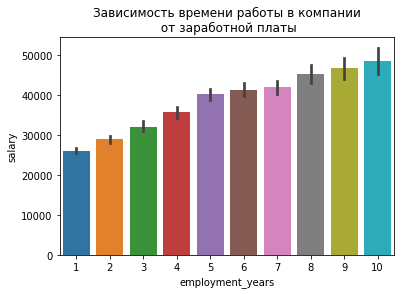

In [19]:
sns.barplot(x='employment_years', y='salary', data=train_job_satisfaction_rate)
plt.title('Зависимость времени работы в компании\n от заработной платы')
plt.show()

На графике видно, что средняя разаботная плата повышается в зависимости от выслуги лет. 

In [20]:
print('Средняя зарплата сотрудников, чей стаж 8 лет и выше', 
      train_job_satisfaction_rate[train_job_satisfaction_rate['employment_years'] >= 8]['salary'].mean())

print('Средняя зарплата сотрудников, чей стаж ниже 8 лет', 
      train_job_satisfaction_rate[train_job_satisfaction_rate['employment_years'] < 8]['salary'].mean())

Средняя зарплата сотрудников, чей стаж 8 лет и выше 46301.44927536232
Средняя зарплата сотрудников, чей стаж ниже 8 лет 32498.04796430563


Средняя зарплата сотрудников чей стаж работы в компании выше 8 лет почти на 14000 больше, нежели у сотрудников, которые проработали меньше. Посмотрим среднюю оценку удовлетворенности работой у таких сотрудников.

____

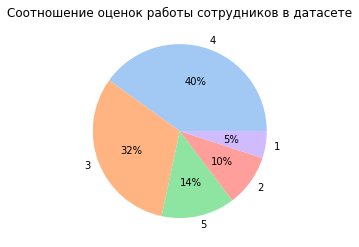

In [21]:
labels = train_job_satisfaction_rate['supervisor_evaluation'].value_counts().index
sizes = train_job_satisfaction_rate['supervisor_evaluation'].value_counts().values

colors = sns.color_palette('pastel')[ 0:5 ]

plt.pie(sizes, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Соотношение оценок работы сотрудников в датасете')
plt.show()

На графике видно, что всего лишь у 14% сотрудников работа была оценена на 5 баллов. Большую долю оценок в датасете заняли 4. И почти половина (47%) сотрудников получили оценки от 3 и ниже. Это может говорить о низкой эффективности работы сотрудников или же о строгой оценке их руководителей. Посмотрим средние оценки работы сотрудников по отделам.

In [22]:
train_job_satisfaction_rate.groupby(['dept'])['supervisor_evaluation'].median().sort_values(ascending=False)

dept
marketing     4
purchasing    4
sales         4
technology    4
hr            3
Name: supervisor_evaluation, dtype: int64

Судя по медианным оценкам руководитель HR отдела ниже всего оценивает работу своих сотрудников

In [23]:
print('Количество сотрудников, получивших оценку 1 -', 
      train_job_satisfaction_rate[train_job_satisfaction_rate['supervisor_evaluation'] == 1]['id'].count())

Количество сотрудников, получивших оценку 1 - 201


201 сотрудник получили оценку 1 за свою работу. Посмотрим в каких отделах чаще всего наблюдается такая ситуация, посчитав процентное соотношение числа сотрудников, получивших низкую оценку своей работы.

In [24]:
count_1 = train_job_satisfaction_rate[train_job_satisfaction_rate['supervisor_evaluation'] == 1].groupby('dept').size()  
total_count = train_job_satisfaction_rate.groupby('dept').size()
print((count_1 / total_count * 100).round(2).sort_values(ascending=False))

dept
purchasing    7.70
hr            5.04
technology    4.73
sales         4.43
marketing     4.18
dtype: float64


Самый большой процент низкооцененных сотрудников наблюдается в отделе снабжения. Возможно руководитель отдела считает, что  снабжение недостаточно хорошо взаимодействует с поставщиками или же плохо выбирает лучшие предложения от них. Также есть вероятность того, что сотрудники пользуются откатами и руководство это знает, поэтому занижает оценку их деятельности.

___

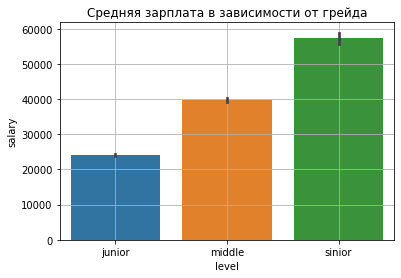

In [25]:
sns.barplot(data=train_job_satisfaction_rate, x='level', y='salary')
plt.title('Средняя зарплата в зависимости от грейда')
plt.grid(True)
plt.show()

на диаграмме видно, что грейд сотрудников напрямую влияет на среднюю зарплату:

- средняя зарплата джунов приблизительно равна 24000
- средняя зарплата мидлов 40000
- средняя зарплата серьоров 58000

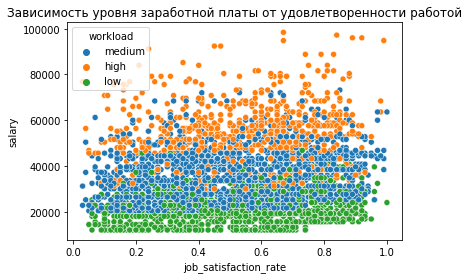

In [26]:
sns.scatterplot(data=train_job_satisfaction_rate, x='job_satisfaction_rate', y='salary', hue='workload')
plt.title('Зависимость уровня заработной платы от удовлетворенности работой')
plt.show()

Видимая зависимость в данных отсутствует.
___

In [27]:
train_job_satisfaction_rate[train_job_satisfaction_rate['workload'] == 'high']['dept'].value_counts(normalize=True).sort_values(ascending=False)

sales         0.376535
technology    0.223738
purchasing    0.166439
marketing     0.139154
hr            0.094134
Name: dept, dtype: float64

Данные говорят нам, что самая большая нагрузка у сотрудников отдела продаж. Ниже посмотрим какой уровень удовлетворенности работой в компании у самого большого по численности сотрудников отдела.
___

In [28]:
train_job_satisfaction_rate[train_job_satisfaction_rate['job_satisfaction_rate'] <= 0.2].drop('id', 1).describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,392.000000,392.000000,392.000000,392.000000
mean,2.487245,2.477041,30645.918367,0.142347
std,1.845667,0.714829,14649.428772,0.042853
min,1.000000,1.000000,12000.000000,0.030000
25%,1.000000,2.000000,20400.000000,0.110000
50%,2.000000,3.000000,26400.000000,0.150000
75%,4.000000,3.000000,38400.000000,0.180000
max,10.000000,3.000000,76800.000000,0.200000


Проанализировав работников, уровень удовлетворенности работой в компании у которых 0.2 и ниже можно увидеть следующие закономерности:

- Средняя зарплата у таких сотрудников составила почти 31000 рублей. Проблема столь низкой оценки тут явно не связана с зарплатой, т.к. средняя зп по всему датасету составила 34000
- Среднее время продолжительности работы в компании у таких сотрудников составило 2.5 года. При этом по всему датасету средняя продолжительность работы сотрудника в компании составила 3.7. Такие сотрудники реже задерживаются в компании.


Теперь посмотрим как часто такие сотрудники нарушали трудовой договор

In [29]:
train_job_satisfaction_rate[train_job_satisfaction_rate['job_satisfaction_rate'] <= 0.2]['last_year_violations'].value_counts()

yes    202
no     190
Name: last_year_violations, dtype: int64

202 сотрудника из недовольных работой в компании нарушали трудовой договор. Это почти половина всех нарушителей по всему датасету. Видно их настолько не устраивали условия работы в компании, что их оценка удовлетворенности упала ниже 0.2. При этом можно предположить, что в числе недовольных сотрудников много неуправляемых, раз трудовой договор так часто нарушался. 


In [30]:
train_job_satisfaction_rate[train_job_satisfaction_rate['dept'] == 'sales']['job_satisfaction_rate'].describe()

count    1512.000000
mean        0.533757
std         0.228254
min         0.030000
25%         0.350000
50%         0.570000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

В целом сотрудники отдела продаж довольны работой в компании. Статистики почти не отличаются от статистик по всему датасету

In [31]:
train_job_satisfaction_rate[train_job_satisfaction_rate['last_year_violations'] == 'yes'].drop('id', 1).describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,559.000000,559.000000,559.000000,559.000000
mean,3.871199,2.944544,34087.298748,0.320000
std,2.575291,0.934486,15182.912239,0.193081
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,2.000000,22800.000000,0.160000
50%,3.000000,3.000000,30000.000000,0.300000
75%,6.000000,4.000000,44400.000000,0.440000
max,10.000000,5.000000,91200.000000,0.740000


У нарушивших трудовой договор сотрудников средние показатели не сильно ушли от среднего по всему датасету. Тут нечего смотреть.
___

#### EDA test_features

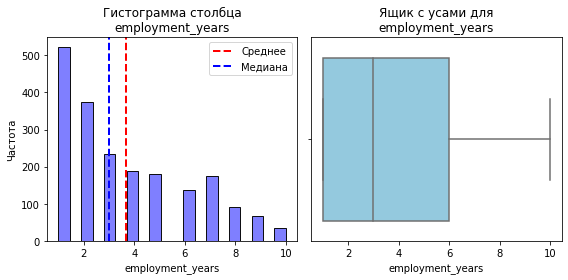

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


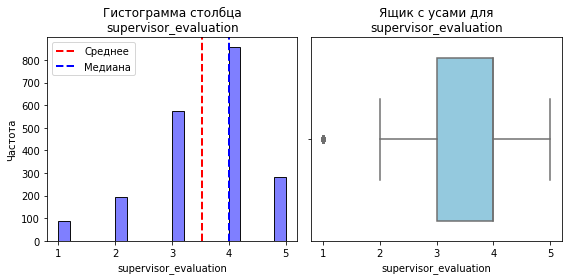

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


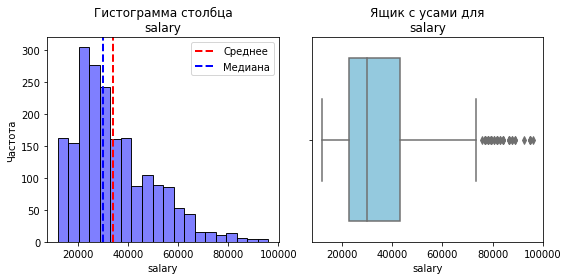

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


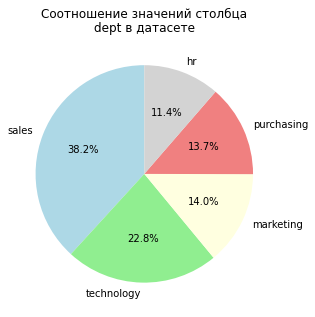

sales         763
technology    455
marketing     279
purchasing    273
hr            227
Name: dept, dtype: int64


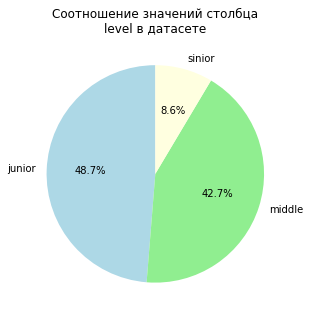

junior    974
middle    854
sinior    171
Name: level, dtype: int64


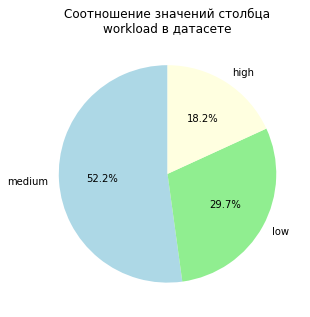

medium    1043
low        593
high       363
Name: workload, dtype: int64


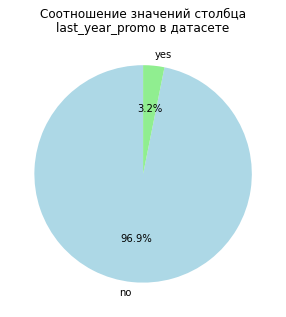

no     1937
yes      63
Name: last_year_promo, dtype: int64


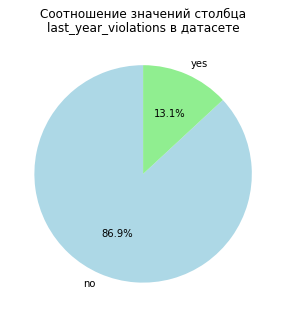

no     1738
yes     262
Name: last_year_violations, dtype: int64


In [32]:
eda(test_features.drop('id', 1))

Все статистики совпадают с тренировочной выборкой, нам нечего исследовать. Но можно посмотреть какие строки имеют пропущенные значения и почему

In [33]:
test_features.isnull().sum()

id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [34]:
test_features[test_features.isna().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
813,471990,sales,NaN,low,1,no,no,3,12000
1100,590867,marketing,junior,NaN,4,no,no,4,28800
1140,609865,NaN,junior,medium,1,no,no,1,20400
1609,822186,NaN,middle,medium,3,no,no,4,38400
1637,832342,NaN,junior,medium,1,no,no,4,28800


Вероятно, причиной этих пропусков стал человеческий фактор. В ходе подготовки данных используем SimpleImputer со стратегией most_frequent. Таким образом:
- пропуски в столбце `dept` заполнятся на sales
- пропуски в столбце `level` заполнятся на junior
- пропуски в столбце `workload` заполнятся на medium
___

#### EDA test_target_job_satisfaction_rate

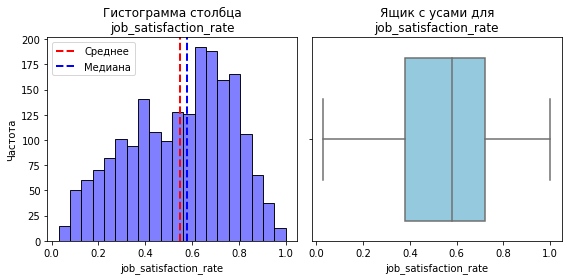

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64


In [35]:
eda(test_target_job_satisfaction_rate.drop('id', 1))

Столбец с целевой переменной `job_satisfaction_rate`:
- Средняя оценка удовлетворенности работой в компании составила 0.55. Это чуть выше, чем у тренировочной выборки.

#### Вывод по исследовательскому анализу данных

В ходе исследовательского анализа данных были выявлены следующие особенности в данных:

Начнем со столбца `employment_years`:
- Средняя длительность пребывания работников в компании составила 3.7 лет. При этом медианное значение составило 3
- Чем дольше сотрудник работает в компании, тем выше его заработная плата. Так, у сотрудников, работающих 5 лет и больше средняя зарплата превышает 40000 рублей
_____
Следом идет оценка качества работы сотрудника, которую дал руководитель `supervisor_evaluation`:
- Наиболее популярная оценка, которую дали руководители, оценивая работу своих сотрудников, составила 4. При этом средняя оценка составила 3.5, что свидетельствует том, что мало руководителей оценили работу своих сотрудников на 5. 
- Лишь у 14% сотрудников работа была оценена на 5 баллов. Большую долю оценок в датасете заняли 4. И почти половина (47%) сотрудников получили оценки от 3 и ниже. Это может говорить о низкой эффективности работы сотрудников или же о строгой оценке их руководителей
- 201 сотрудник получили оценку 1 за свою работу. Самый большой процент низкооцененных сотрудников наблюдается в отделе снабжения. Возможно руководитель отдела считает, что снабжение недостаточно хорошо взаимодействует с поставщиками или же плохо выбирает лучшие предложения от них. Также есть вероятность того, что сотрудники пользуются откатами и руководство это знает, поэтому занижает оценку их деятельности.
___
Далее идет столбец с зарплатами в компании `salary`:
- Большая часть работников имеет зарплату до 400000 рублей
- Средняя зарплата в компании составила почти 34000 рублей. При этом медиана составила 30000 рублей, что свидетельствует о наличие выбросов справа от медианы. Это можно увидеть и на ящике с усами. Из-за того, что большая часть компании имеет зарплату до 40000 рублей все, кто имеет зарплату от ~72000 и выше - составили выбросы. Их мы удалять не будем, так как зарплаты менеджеров выше, нежели чем у линейных сотрудников и это тоже нужно учитывать при моделировании. 
- Грейд сотрудников напрямую влияет на уровень заработной платы. Так, средняя зарплата джунов приблизительно равна 24000, средняя зарплата мидлов 40000, средняя зарплата серьоров 58000
___
Столбец с целевой переменной `job_satisfaction_rate`:
- Есть сотрудники, уровень удовлетворенности работы которых составил 0.03. 
- Средняя оценка удовлетворенности работой в компании составила 0.53. Максимсальная оценка составила 1.
- Проанализировав работников, уровень удовлетворенности работой в компании у которых 0.2 и ниже можно увидеть следующие закономерности: Средняя зарплата у таких сотрудников составила почти 31000 рублей. Проблема столь низкой оценки тут явно не связана с зарплатой, т.к. средняя зп по всему датасету составила 34000 Среднее время продолжительности работы в компании у таких сотрудников составило 2.5 года. При этом по всему датасету средняя продолжительность работы сотрудника в компании составила 3.7. Такие сотрудники реже задерживаются в компании.
- 202 сотрудника из недовольных работой в компании нарушали трудовой договор. Это почти половина всех нарушителей по всему датасету. Видно их настолько не устраивали условия работы в компании, что их оценка удовлетворенности упала ниже 0.2. При этом можно предположить, что в числе недовольных сотрудников много неуправляемых, раз трудовой договор так часто нарушался.
___
Подразделения компании представлены на круговой диаграмме с данными столбца `dept`:
- Всего в компании 5 подразделений
- Наибольшее по численности нанятых сотрудников подразделение - Продажи. Там находится 37.9% сотрудников компании.
- Далее у нас идет технологический отдел, его численность составили 866 сотрудников - 21.7%
- Снабжение, HR и маркетинг имеют примерно одинаковую долю в компании - 15.3%, 11.4%, 13.8% соответственно.
___
На очереди уровень грейда сотрудников компании `level`:
- Основная масса сотрудников компании состоит из специалистов уровней middle и junior - 43.6% и 47.4% соответственно
- Sinior - самый высший грейд - составили 9% сотрудников. Их не так много в компании. Скорее всего это связано либо со сложным уровнем аттестации для сотрудников данного грейда или же с ориентацией компании на молодых и неопытных сотрудников, которых проще обучить под собственные стандарты. Во всяком случае это нормальная картина, что в компании мало Sinior сотрудников.
___
Столбец `workload`:
- Чуть больше половины сотрудников компании имеют средний уровень нагрузки
- Лишь 18% сотрудников компании имеют высокий уровень нагрузки в компании. При этом отдел продаж имеет наибольшую нагрузку
___
Диаграмма для `last_year_promo` содержит информацию о повышениях. Вот что удалось выяснить:
- За последний год получили повышение только 120 сотрудников компании. Это всего лишь 3% сотрудников. Есть ощущение, что в компании либо недостаточно прозрачная система роста сотрудников, либо слишком сложные условия для повышения грейда. 
___
Диаграмма для `last_year_violations` содержит информацию о том, нарушал ли сотрудник трудовой договор. Вот что удалось выяснить:
- 14% сотрудников компании имеют пометки о нарушениях трудового договора за последний год.
___

## Корреляционный анализ

Для корреляционного анализа используем коэффициент Фик корелляции и построим хитмэп. Фик мы берем для оценки как количественных, так и категориальных признаков и их зависимостей

In [36]:
phik_matrix = train_job_satisfaction_rate.drop('id', 1).phik_matrix(
    interval_cols=['employment_years', 'supervisir_evaluation', 'salary', 'job_satisfaction_rate']
)

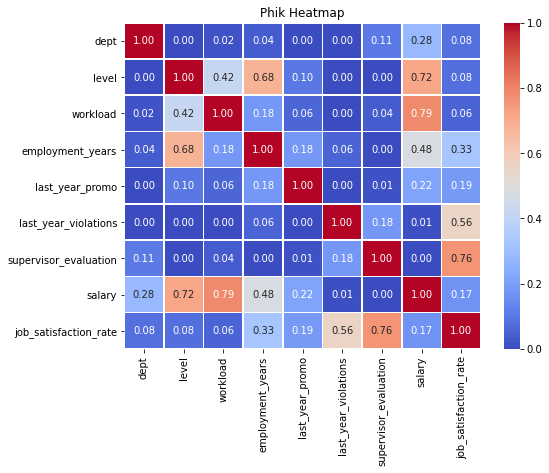

In [37]:
plt.figure(figsize=(8, 6))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Phik Heatmap")
plt.show()

#### Вывод по корреляционному анализу

В ходе корреляционного анализа мы были замечаны следующие наблюдения:
- С целевой переменной замечена сильная положительная корреляция у признака с оценкой работы сотрудников
- Повышенная положительная корелляция также обнаружена между  такими признаками, как грей сотрудника и стаж работы с заработной платой. Оно и понятно, т.к. стаж напрямую влияет на уровень компетентности, а уровень компетентности на зарплату.
- Также стоит обратить внимание на повышенную корреляцию между уровнем нагрузки и заработной платой: чем выше нагрузка, тем выше и зарплата.

Тем не менее, т.к. линейной зависимости между количественными признаками нет, признаки для обучения мы оставим прежние.

## Пайплайн 1

Для подготовки нашего пайплайна мы используем 2 модели, среди которых одна будет линейной, а другая - дерево решений:

- LinearRegression
- DesicionTreeRegressor(max_depth, min_samples_split, random_state)

Для оценки качества моделей для начала напишем функцию для подсчета метрики SMAPE. По условию, нам важно, чтобы метрика лушчей модели была <= 15. Перед тем, как начать строить пайплайн и подготавливать данные для обучения модели, напишем метрику для оценки качества модели.

В ходе предобработки будем прописывать следующие этапы:
- Масштабирование количественных признаков(StandartScaler, MinMaxScaler, RobustScaler)
- Кодирование категориальных признаков(OrdinalEncoder, OneHotEncoder)

Пропуски в данных заполним с помощью SimpleImputer со стратегией most frequent

Для перебора применим RandomizedSearchCV

Столбцы для предобработки:
- Категориальные(dept, **level**, **workload**, last_year_promo, last_year_violations, **supervisor_evaluation**)
- Количественные(employment_years, salary)

Жирным шрифтом мы выделили столбцы, которые будем кодировать OrdinalEncoder, т.к. порядок там имеет значение.

In [38]:
def smape(a, f):
    return 100 / len(a) * np.sum(2 * np.abs(f - a) / (np.abs(a) + np.abs(f) + np.finfo(float).eps))

scorer = make_scorer(smape, greater_is_better=False)

In [39]:
x_train = train_job_satisfaction_rate.drop(['id','job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']

RANDOM_STATE=12345

In [40]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload', 'supervisor_evaluation']
num_columns = ['employment_years', 'salary']

In [41]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),    
         ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
) 

ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
        ('ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                    [1, 2, 3, 4, 5],
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan)), 
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
]) 

In [42]:
%%time

param_distributions = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_split': range(2, 20),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']  
    }
] 

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring=scorer, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(x_train, y_train) 

CPU times: user 1.79 s, sys: 7.3 ms, total: 1.8 s
Wall time: 1.8 s


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=...
                                                                          random_state=12345)],
                                         'models__max_depth': range(2, 20),
                                         'models__min_samples_split': range(2, 20),
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=12345,
                   scoring=make_scorer(smape, greater_is_better=False))

In [43]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

In [44]:
print('Метрика SMAPE для лучшей модели:', randomized_search.best_score_)

Метрика SMAPE для лучшей модели: -14.860274336045174


При использовании make_scorer с greater_is_better=False автоматически изменяется знак возвращаемого значения метрики, чтобы адаптировать её к стандартным функциям оптимизации, которые предполагают, что большие значения лучше. Так как в нашем случае лучше - это меньшие значения, соответственно знак возвращается отрицательный. Но при интерпретация метрики будет звучать так: среднее абсолютное процентное отклонение между нашими прогнозами и реальными значениями составляет 14.86% 

In [45]:
print('Метрика SMAPE на тестовой выборке:', smape(test_target_job_satisfaction_rate['job_satisfaction_rate'], 
                                                    randomized_search.predict(test_features.drop('id', 1))))

Метрика SMAPE на тестовой выборке: 13.665833338005095


Наша модель выдает еще меньше ошибок на тестовой выборке! Это значит что она хорошо улавливает закономерности на новых данных. Это хороший показатель

#### Вывод по Задаче 1

В ходе написания пайплайна и выбора лучшей модели с помощью метрики SMAPE была найдена лучшая модель, отвечающая требованиям задачи. Лучшая модель - DecisionTreeRegressor(max_depth=17, min_samples_split=10, random_state=12345). Масштабирование не нужно. Метрика на тесте составила 13.67 Это означает, что среднее абсолютное процентное отклонение между нашими прогнозами и реальными значениями составляет 13.67%

## Задача 2. Загрузка данных

In [46]:
train_quit = pd.read_csv('/datasets/train_quit.csv', decimal='.')
print(train_quit.info())
train_quit.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


In [47]:
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv', decimal='.')
print(test_target_quit.info())
test_target_quit.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


#### Вывод по первичному осмотру
Данные те же самые, пропусков в них нет. На предобработке посмотрим есть ли какие-то аномалии в новом признаке. На всякий случай проверим датафрейм с тренировочными данными

## Предобработка данных

Количество дубликатов: 1413

Cписок уникальных значений для столбца dept
['sales' 'purchasing' 'marketing' 'technology' 'hr']

Cписок уникальных значений для столбца level
['middle' 'junior' 'sinior']

Cписок уникальных значений для столбца workload
['high' 'medium' 'low']

Cписок уникальных значений для столбца last_year_promo
['no' 'yes']

Cписок уникальных значений для столбца last_year_violations
['no' 'yes']

Cписок уникальных значений для столбца quit
['no' 'yes']

Cписок уникальных значений для столбца employment_years
[ 1  2  3  4  5  6  7  8  9 10]

Cписок уникальных значений для столбца supervisor_evaluation
[1 2 3 4 5]

Cписок уникальных значений для столбца salary
[12000 13200 14400 15600 16800 18000 19200 20400 21600 22800 24000 25200
 26400 27600 28800 30000 31200 32400 33600 34800 36000 37200 38400 39600
 40800 42000 43200 44400 45600 46800 48000 49200 50400 51600 52800 54000
 55200 56400 57600 58800 60000 61200 62400 63600 64800 66000 67200 68400
 69600 70800 72000 7320

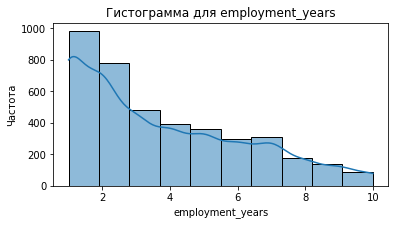

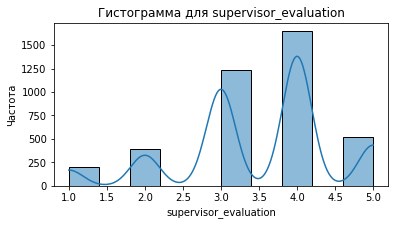

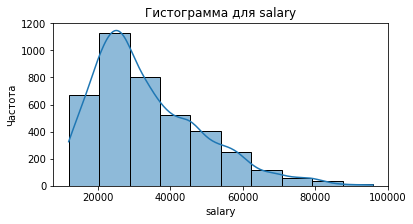

In [48]:
check_data(train_quit.drop('id', 1))

In [49]:
check_data(test_target_quit.drop('id', 1))

Количество дубликатов: 1998

Cписок уникальных значений для столбца quit
['yes' 'no']



In [50]:
train_quit = train_quit.sort_values('id').reset_index(drop=True)
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,100222,sales,junior,medium,3,no,no,2,20400,yes
1,100459,purchasing,junior,medium,3,no,no,3,21600,yes
2,100469,marketing,junior,medium,1,no,no,4,28800,no
3,100601,technology,middle,high,4,no,no,4,68400,no
4,100858,sales,junior,medium,2,no,no,4,25200,yes


In [51]:
test_target_quit = test_target_quit.sort_values('id').reset_index(drop=True)
test_target_quit.head()

,id,quit
0,100298,no
1,100480,no
2,100503,no
3,100610,no
4,100692,no


#### Вывод по предобработке
Никаких аномалий, пропусков, дубликатов в данных не обнаружено, предобработкой заниматься не нужно.

## Исследовательский анализ данных

Т.к. исследовательский анализ данных был проведен в начале работы, рассмотрим характер нового целевого признака и приступим к дополнительным исследованиям

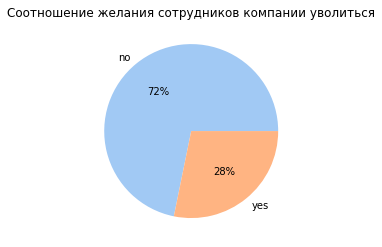

In [52]:
labels = train_quit['quit'].value_counts().index
sizes = train_quit['quit'].value_counts().values

colors = sns.color_palette('pastel')[ 0:5 ]

plt.pie(sizes, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Соотношение желания сотрудников компании уволиться')
plt.show()

28% сотрудников компании в датасете уволились. Классы несбалансированы. Далее проведем анализ портрета уволившегося сотрудника. 

In [53]:
train_quit[train_quit['quit'] == 'yes'].drop('id', 1).describe()

,employment_years,supervisor_evaluation,salary
count,1128.000000,1128.000000,1128.000000
mean,1.844858,3.046099,23885.106383
std,1.274920,0.973291,9351.599505
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,16800.000000
50%,1.000000,3.000000,22800.000000
75%,2.000000,4.000000,27600.000000
max,10.000000,5.000000,79200.000000


Давайте изучим основные статистики количественных признаков уволившихся сотрудников:
- Средняя продолжительность работы в компании таких сотрудников составила почти 2 года (1.8 лет)
- Средняя оценка работы уволившегося сотрудника составила 3
- Средняя зарплата составила почти 24000. Медианная зарплата и вовсе ниже - почти 23000

Теперь изучим статистики для тех, кто из компании не уволился и сравним их

In [54]:
train_quit[train_quit['quit'] == 'no'].drop('id', 1).describe()

,employment_years,supervisor_evaluation,salary
count,2872.000000,2872.000000,2872.000000
mean,4.430710,3.643106,37702.228412
std,2.544635,0.965295,15218.977339
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,25200.000000
50%,4.000000,4.000000,34800.000000
75%,6.000000,4.000000,46800.000000
max,10.000000,5.000000,96000.000000


- Средняя продолжительность работы в компании составила почти 4.5 года
- Средняя оценка работы сотрудников составила 3.6
- Средняя зарплата составила почти 38000. Медианная - около 35000

Сравнивая статистики по обеим выборкам можно сделать следующие выводы:
- Средняя продолжительность работы в компании уволившегося сотрудника в 2.5 раза меньше, чем у того, который в компании останется 
- Средняя оценка работы на 0.5 ниже у уволившегося сотрудника
- Средняя зарплата уволившегося сотрудника в 1.5 раза меньше, нежели у тех, кто остался работать в компании.

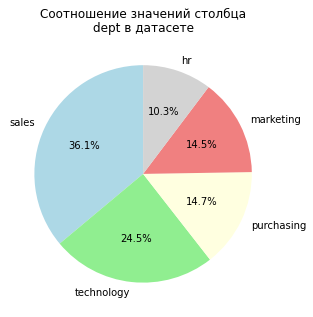

sales         407
technology    276
purchasing    166
marketing     163
hr            116
Name: dept, dtype: int64


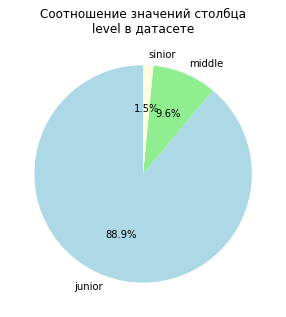

junior    1003
middle     108
sinior      17
Name: level, dtype: int64


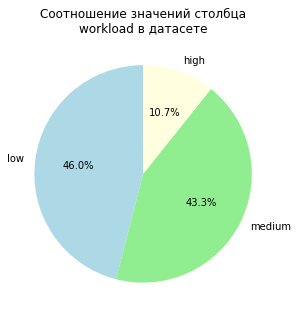

low       519
medium    488
high      121
Name: workload, dtype: int64


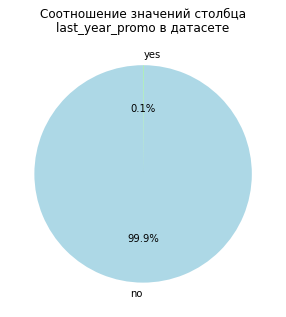

no     1127
yes       1
Name: last_year_promo, dtype: int64


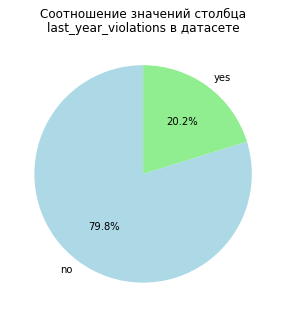

no     900
yes    228
Name: last_year_violations, dtype: int64


In [55]:
eda(train_quit[train_quit['quit'] == 'yes'].drop(['id', 'employment_years', 'supervisor_evaluation', 'salary', 'quit'], 1))

Портер уволившегося сотрудника: 
- Работает в отделе продаж или в техническом отделе (в меньшей степени);
- Уровень сотрудника - junior;
- Уровень загруженности сотрудника либо низкий, либо средний;
- За последний год не получал повышений
- В 20% случаев такой сотрудник нарушает трудовой договор
- Средняя продолжительность работы составляет около 2 лет
- Средняя оценка работы 3
- Средняя зарплата около 24000
____

Есть предположение, что уровень удовлетворенности сотрудника влияет на то, уволится ли он. Проверим это предположение

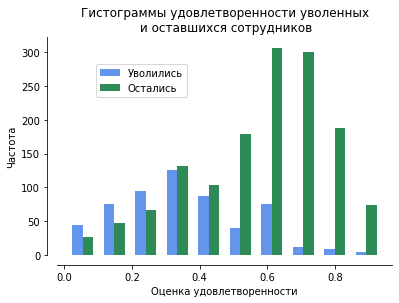

In [56]:
comparing = pd.concat([test_target_job_satisfaction_rate['job_satisfaction_rate'], test_target_quit['quit']], 1)
yes = comparing[comparing['quit'] == 'yes']
no = comparing[comparing['quit'] == 'no']

fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(yes['job_satisfaction_rate'])
b_heights, b_bins = np.histogram(no['job_satisfaction_rate'], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue', label='Уволились')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen', label='Остались')

ax.legend(['Уволились', 'Остались'], loc='center left', bbox_to_anchor=(0.1, 0.8))

plt.title('Гистограммы удовлетворенности уволенных\n и оставшихся сотрудников')
plt.xlabel('Оценка удовлетворенности')
plt.ylabel('Частота')

sns.despine(ax=ax, offset=10)


На графике видно, что синяя гистограмма (уволившиеся сотрудники) смещена влево от зеленой (оставшиеся сотрудники). Такое расположение гистограмм относительно оси X, где отображены значения уровня удовлетворенности сотрудников работой в компании, говорит нам о том, что, действительно, есть зависимость между уровнем удовлетворенности работой и уволится ли сотрудник. Проглядывается следующая тенденция: Средний уровень удовлетворенности уволившихся сотрудников составил 0.3, а средний уровень удовлетворенности оставшихся сотрудников составил 0.6 - получается, что у уволившихся сотрудников средний уровень удовлетворенности работой в 2 раза меньше, чем у оставшихся. 

#### Вывод по исследовательскому анализу

В ходе исследовательского анализа данных был составлен портер уволившегося сотрудника:
- Работает в отделе продаж или в техническом отделе (в меньшей степени);
- Уровень сотрудника - junior;
- Уровень загруженности сотрудника либо низкий, либо средний;
- За последний год не получал повышений
- В 20% случаев такой сотрудник нарушает трудовой договор
- Средняя продолжительность работы составляет около 2 лет
- Средняя оценка работы 3
- Средняя зарплата около 24000

Также была выявлена зависимость между уровнем удовлетворенности работой сотрудника и его решением уволиться. У уволившихся сотрудников средний уровень удовлетворенности составил 0.3. Этот признак нам необходим для более точного прогноза увольнения, поэтому добавим его в ходе обучения. 

## Добавление нового признака

Мы выяснили, что оценка удовлетворенности сотрудника - это хороший входной признак для прогноза таргета по увольнению. В тренировочную выборку добавим таргет из первой задачи в тренировочном датасете, а в тестовую выборку с входными признаками добавим спрогнозированные нашей лучшей моделью оценки удовлетворенности. 

In [57]:
train_quit['rate'] = train_job_satisfaction_rate.sort_values('id')['job_satisfaction_rate']
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,rate
0,100222,sales,junior,medium,3,no,no,2,20400,yes,0.58
1,100459,purchasing,junior,medium,3,no,no,3,21600,yes,0.76
2,100469,marketing,junior,medium,1,no,no,4,28800,no,0.11
3,100601,technology,middle,high,4,no,no,4,68400,no,0.37
4,100858,sales,junior,medium,2,no,no,4,25200,yes,0.20


In [58]:
test_features['rate'] = randomized_search.predict(test_features.drop('id', 1))
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,rate
0,100298,hr,junior,low,2,no,no,4,19200,0.837500
1,100480,marketing,junior,low,4,no,no,4,16800,0.852000
2,100503,purchasing,middle,high,5,no,no,4,55200,0.746667
3,100610,sales,middle,medium,5,no,no,4,43200,0.810000
4,100692,sales,middle,high,6,no,no,4,48000,0.700000


## Корреляционный анализ

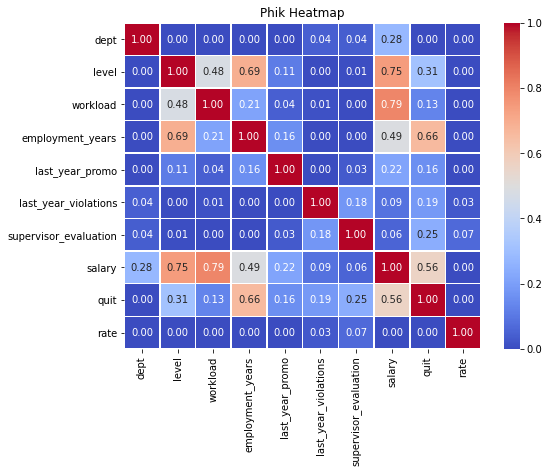

In [59]:
phik_matrix = train_quit.drop('id', 1).phik_matrix(
    interval_cols=['employment_years', 'supervisir_evaluation', 'salary', 'job_satisfaction_rate']
)

plt.figure(figsize=(8, 6))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Phik Heatmap")
plt.show()

#### Вывод по корреляционному анализу

В ходе корреляционного анализа мы были замечаны следующие наблюдения:
- С целевой переменной замечена умеренная положительная корреляция у признака со стажем работы. Небольшая положительная корреляция также обнаружена и с признаком Заработная плата.
- Повышенная положительная корелляция также обнаружена между  такими признаками, как грей сотрудника и стаж работы с заработной платой. Оно и понятно, т.к. стаж напрямую влияет на уровень компетентности, а уровень компетентности на зарплату.
- Также стоит обратить внимание на повышенную корреляцию между уровнем нагрузки и заработной платой: чем выше нагрузка, тем выше и зарплата.

Тем не менее, т.к. линейной зависимости между количественными признаками нет, признаки для обучения мы оставим прежние.

## Пайплайн 2

Для нашего пайплайна мы используем 3 модели:

- LogisticRegression(solver, class_weight='balanced', random_state, max_iter)
- DesicionTreeClassifier(class_weight='balanced', max_depth, min_samples_split, random_state, min_samples_leaf)
- KNeighborsClassifier


Где можем - указываем class weight, т.к. наши данные не сбалансированы
Для оценки качества моделей будем использовать ROC-AUC

Предобработку данных оставим прежней, изменится число признаков 

Для перебора применим RandomizedSearchCV

Столбцы для предобработки:
- Категориальные(dept, **level**, **workload**, last_year_promo, last_year_violations, **supervisor_evaluation**)
- Количественные(employment_years, salary, rate)

Жирным шрифтом мы выделили столбцы, которые будем кодировать OrdinalEncoder, т.к. порядок там имеет значение.

In [60]:
x_train = train_quit.drop(['id', 'quit'], 1)
y_train = train_quit['quit']

num_columns = ['employment_years', 'salary', 'rate']

In [61]:
data_preprocessor_2 = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final= Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
]) 

In [62]:
%%time

param_distributions = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_split': range(2, 20),
        'models__min_samples_leaf': range(1, 19),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']    
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE)],
        'models__solver': ['liblinear', 'lbfgs', 'sag', 'saga'],
        'models__max_iter': range(100, 1000),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough']
    }
] 

randomized_search_2 = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_2.fit(x_train, y_train) 

CPU times: user 4.22 s, sys: 2.24 s, total: 6.46 s
Wall time: 7.37 s


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=...
                                                                       random_state=12345,
                                                                       solver='liblinear')],
                                         'models__max_iter': range(100, 1000),
                                         'models__solver': ['liblinear',
                                                            'lbfgs', 'sag',
                                                            'saga'],
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=12345, scoring='roc_auc')

In [63]:
print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_) 

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

In [64]:
print('Метрика roc-auc для лучшей модели:', randomized_search_2.best_score_)

Метрика roc-auc для лучшей модели: 0.925562902084053


In [65]:
print('Метрика roc-auc на тестовой выборке:\n', roc_auc_score(test_target_quit['quit'], randomized_search_2.predict_proba(test_features)[:, 1]))

Метрика roc-auc на тестовой выборке:
 0.9171543787905727


#### Вывод по Задаче 2 
Мы добились успеха! Наша метрика, на тесте составила 0.92! При этом лучшей моделью оказалось DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=3, min_samples_split=17, random_state=12345). Масштабирование делать не нужно.

## Общий вывод

Было необходимо решить две задачи.

Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.


Вторая — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Нам предоставили данные с информацией о сотрудниках. В ходе предобработки данных мы обнаружили пропущенные значения в столбцах с грейдами сотрудников, уровнем загруженности и отделом. Было принято решения заполнить эти пропуски в пайплайне. 

На этапе исследовательского анализа данных были сделаны следующие **важные** наблюдения:

Начнем со столбца `employment_years`:
- Средняя длительность пребывания работников в компании составила 3.7 лет.
- Чем дольше сотрудник работает в компании, тем выше его заработная плата. Так, у сотрудников, работающих 5 лет и больше средняя зарплата превышает 40000 рублей
_____
Следом идет оценка качества работы сотрудника, которую дал руководитель `supervisor_evaluation`:
- Лишь у 14% сотрудников работа была оценена на 5 баллов. Большую долю оценок в датасете заняли 4. И почти половина (47%) сотрудников получили оценки от 3 и ниже. Это может говорить о низкой эффективности работы сотрудников или же о строгой оценке их руководителей
- 201 сотрудник получили оценку 1 за свою работу. Самый большой процент низкооцененных сотрудников наблюдается в отделе снабжения. Возможно руководитель отдела считает, что снабжение недостаточно хорошо взаимодействует с поставщиками или же плохо выбирает лучшие предложения от них. Также есть вероятность того, что сотрудники пользуются откатами и руководство это знает, поэтому занижает оценку их деятельности.
___
Далее идет столбец с зарплатами в компании `salary`:
- Большая часть работников имеет зарплату до 400000 рублей
- Средняя зарплата в компании составила почти 34000 рублей. При этом медиана составила 30000 рублей, что свидетельствует о наличие выбросов справа от медианы. Это можно увидеть и на ящике с усами. Из-за того, что большая часть компании имеет зарплату до 40000 рублей все, кто имеет зарплату от ~72000 и выше - составили выбросы. 
- Грейд сотрудников напрямую влияет на уровень заработной платы. Так, средняя зарплата джунов приблизительно равна 24000, средняя зарплата мидлов 40000, средняя зарплата серьоров 58000
___
Столбец с целевой переменной `job_satisfaction_rate`:
- Средняя оценка удовлетворенности работой в компании составила 0.53.
- Проанализировав работников, уровень удовлетворенности работой в компании у которых 0.2 и ниже можно увидеть следующие закономерности: Средняя зарплата у таких сотрудников составила почти 31000 рублей. Проблема столь низкой оценки тут явно не связана с зарплатой, т.к. средняя зп по всему датасету составила 34000 Среднее время продолжительности работы в компании у таких сотрудников составило 2.5 года. При этом по всему датасету средняя продолжительность работы сотрудника в компании составила 3.7. Такие сотрудники реже задерживаются в компании.
- 202 сотрудника из недовольных работой в компании нарушали трудовой договор. Это почти половина всех нарушителей по всему датасету. Видно их настолько не устраивали условия работы в компании, что их оценка удовлетворенности упала ниже 0.2. При этом можно предположить, что в числе недовольных сотрудников много неуправляемых, раз трудовой договор так часто нарушался.
___
Подразделения компании представлены на круговой диаграмме с данными столбца `dept`:
- Всего в компании 5 подразделений
- Наибольшее по численности нанятых сотрудников подразделение - Продажи. Там находится 37.9% сотрудников компании.
- Далее у нас идет технологический отдел, его численность составили 866 сотрудников - 21.7%
- Снабжение, HR и маркетинг имеют примерно одинаковую долю в компании - 15.3%, 11.4%, 13.8% соответственно.
___
На очереди уровень грейда сотрудников компании `level`:
- Основная масса сотрудников компании состоит из специалистов уровней middle и junior - 43.6% и 47.4% соответственно
- Sinior - самый высший грейд - составили 9% сотрудников. Их не так много в компании. Скорее всего это связано либо со сложным уровнем аттестации для сотрудников данного грейда или же с ориентацией компании на молодых и неопытных сотрудников, которых проще обучить под собственные стандарты. Во всяком случае это нормальная картина, что в компании мало Sinior сотрудников.
___
Столбец `workload`:
- Чуть больше половины сотрудников компании имеют средний уровень нагрузки
- Лишь 18% сотрудников компании имеют высокий уровень нагрузки в компании. При этом отдел продаж имеет самую большую нагрузку
___
В ходе исследовательского анализа данных был составлен портер уволившегося сотрудника:
- Работает в отделе продаж или в техническом отделе (в меньшей степени);
- Уровень сотрудника - junior;
- Уровень загруженности сотрудника либо низкий, либо средний;
- За последний год не получал повышений
- В 20% случаев такой сотрудник нарушает трудовой договор
- Средняя продолжительность работы составляет около 2 лет
- Средняя оценка работы 3
- Средняя зарплата около 24000

Также была выявлена зависимость между уровнем удовлетворенности работой сотрудника и его решением уволиться. У уволившихся сотрудников средний уровень удовлетворенности составил 0.3. Этот признак был нам необходим для более точного прогноза увольнения.


В процессе решения первой задачи по прогнозу уровня удовлетворенности сотрудников работой в компании была написана функция для подсчета метрики SMAPE. В ходе написания пайплайна для поиска лучшей модели наиболее эффективной показала себя  DecisionTreeRegressor(max_depth=17, min_samples_split=10, random_state=12345). Метрика SMAPE на тесте составила 13.67 Это означает, что среднее абсолютное процентное отклонение между нашими прогнозами и реальными значениями составляет 13.67%

В процессе решения второй задачи по прогнозу увольнения сотрудников было принято решение добавить в признаки уровень удовлетворенности сотрудников, т.к. при визуальном анализе зависимости уровня удовлетворенности от увольнения сотрудника выяснилось, что присутствует взаимосвязь с целевой переменной, а именно, что средний уровен удовлетворенности уволенных сотрудников был в 2 раза меньше. При составлении пайплайна наиболее эффективной моделью снова оказалось дерево решений DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=3, min_samples_split=17, random_state=12345) с метрикой roc-auc на тесте 0.92!

Для принятия грамотных решений в ходе оценки кадров рекомендуется учесть пункты, перечисленные в портрете уволенного сотрудника